In [2]:
# from EDA
import dowhy
import dowhy.datasets, dowhy.plotter
from dowhy import CausalModel
from dowhy import causal_estimators
import seaborn as sns
import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Image, display
from utility_functions import *

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot

In [3]:
# import necessary packages
import warnings
warnings.filterwarnings('ignore')

import dowhy
from dowhy import CausalModel

import cdt
cdt.SETTINGS.rpath = '/usr/local/bin/Rscript' # for macOS
# cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.0.3/bin/Rscript' # for Windows

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from numpy.random import normal

from itertools import combinations

In [227]:
df = pd.read_csv('lucas0_train.csv')
df.head()

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


In [228]:
feature_names = list(df.columns)
target_node = 'Lung_cancer'
edges_list = [('Anxiety','Smoking'), ('Peer_Pressure','Smoking'), ('Smoking','Yellow_Fingers'), ('Smoking','Lung_cancer'), 
                  ('Genetics','Lung_cancer'), ('Genetics','Attention_Disorder'), ('Allergy','Coughing'), 
              ('Lung_cancer','Coughing'),('Lung_cancer','Fatigue'), ('Coughing','Fatigue'),('Fatigue','Car_Accident'), 
              ('Attention_Disorder','Car_Accident')]

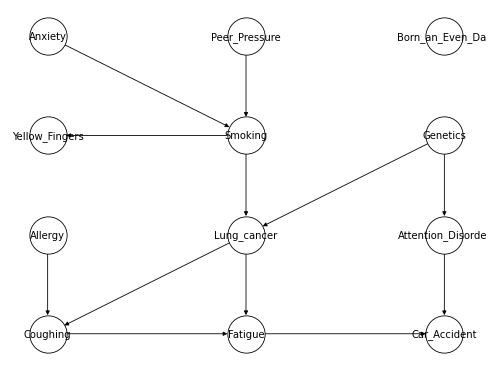

In [229]:
G = nx.DiGraph(directed=True)
G.add_nodes_from(feature_names)
G.add_edges_from(edges_list)

position = {'Anxiety': (-1, 1), 'Peer_Pressure': (0, 1), 'Born_an_Even_Day': (1, 1), 
       'Yellow_Fingers': (-1, 0), 'Smoking': (0, 0),'Genetics': (1, 0), 
       'Allergy': (-1, -1), 'Lung_cancer': (0, -1),'Attention_Disorder': (1, -1),
      'Coughing': (-1, -2), 'Fatigue': (0, -2), 'Car_Accident': (1, -2)}

# color_map = ['yellow' if node == target_node else 'w' for node in G]

fig = plt.figure(1, figsize=(8, 6), dpi=60)
nx.draw(G, pos = position, with_labels=True, node_size=2000, node_color='w', edgecolors ='black')
nx.write_gml(G, "causal_graph_part_5.gml")

# Causal Discovery
- Determine the skeleton
- Determine the v-structures
- Direct as many of the remaining edges as possible.

### 1. Determine the skeleton
The first step is to determine the skeleton. We start with the complete graph with the number of nodes $p$. Then for $k = 0,1,...,p-2$, consider all pairs of vertices $(i, j)$, and remove the edge between them if $X_i$ and $X_j$ are conditionally independent given some subset of size $k$ of $p\setminus(i, j)$.

We create a fully connected graph

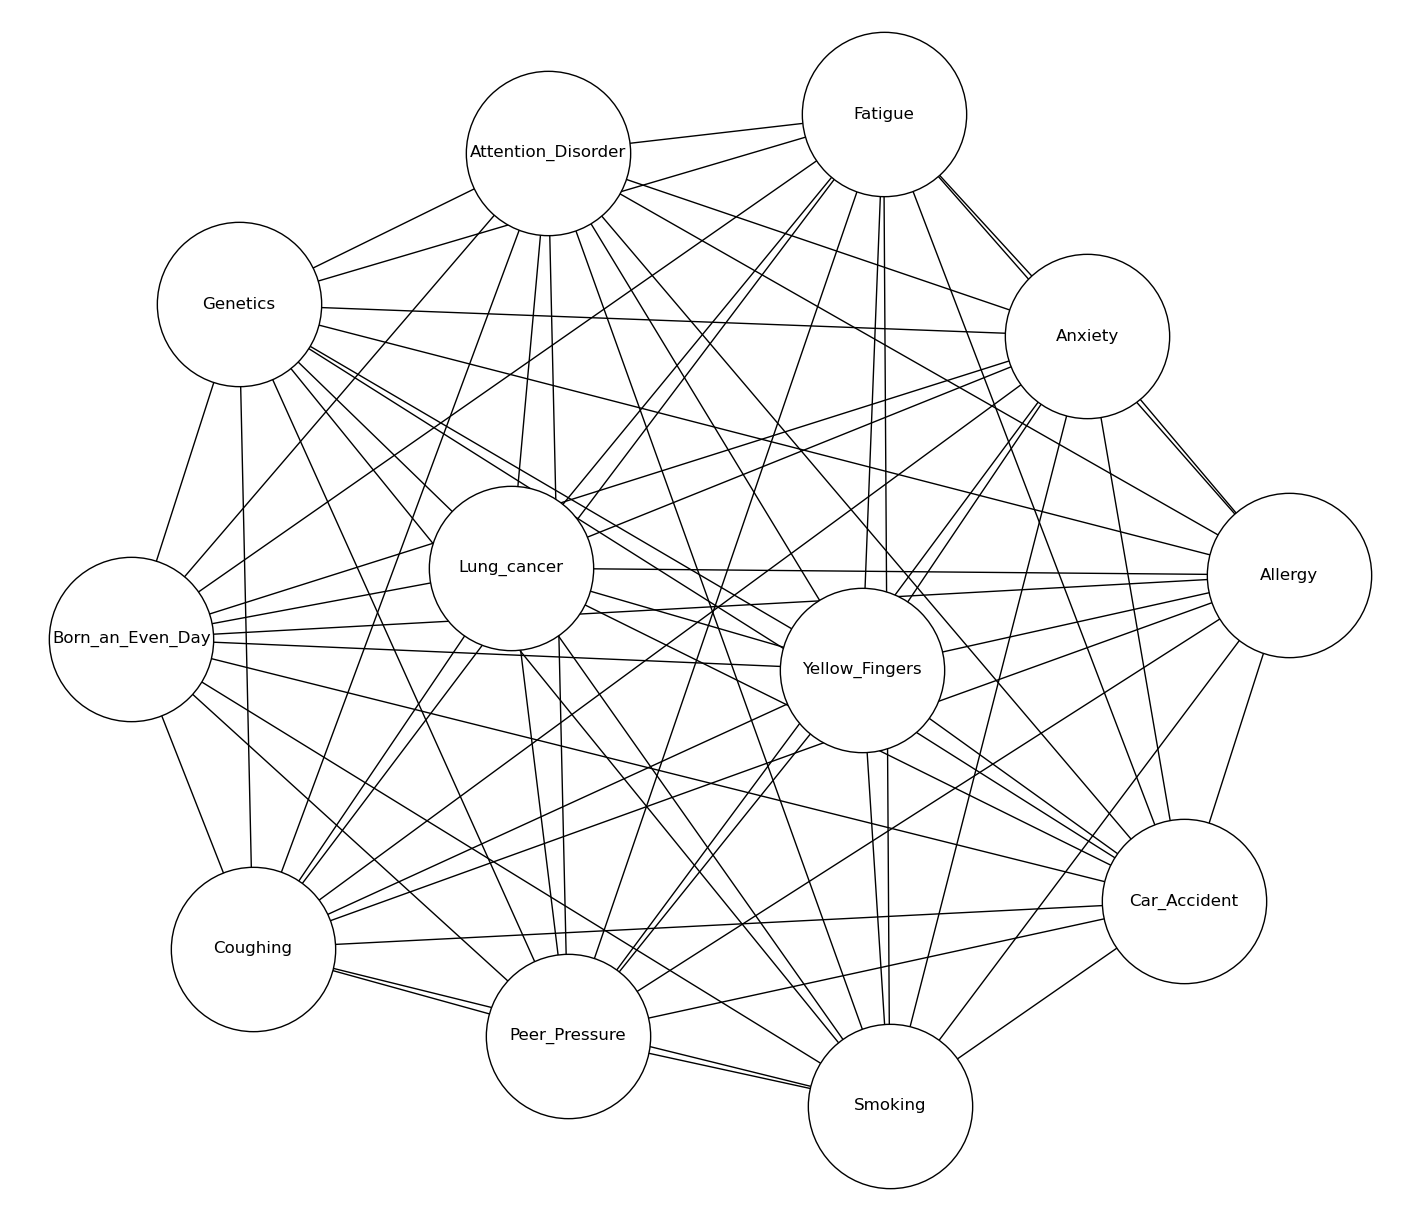

In [230]:
edges = combinations(feature_names, 2)
G = nx.Graph()
G.add_nodes_from(feature_names)
G.add_edges_from(edges, length = 10)

# position = {'Anxiety': (-1, 1), 'Peer_Pressure': (0, 1), 'Born_an_Even_Day': (1, 1), 
#        'Yellow_Fingers': (-1, 0), 'Smoking': (0, 0),'Genetics': (1, 0), 
#        'Allergy': (-1, -1), 'Lung_cancer': (0, -1),'Attention_Disorder': (1, -1),
#       'Coughing': (-1, -2), 'Fatigue': (0, -2), 'Car_Accident': (1, -2)}

fig = plt.figure(1, figsize=(14, 12), dpi=100)
nx.draw(G, with_labels=True, node_size=14000, node_color='w', edgecolors ='black') #, pos=position
nx.write_gml(G, "fully_connected_graph.gml")
# plt.savefig('fully_connected_graph.png')

In [231]:
print("Current number of edges in the graph is ", G.number_of_edges())

Current number of edges in the graph is  66


In **round 1**, We use partial correlation that we introduced in Tutorial 2 to do conditional independence testing. For the first round we test independence between any pair of variables with a conditioning set with size of 0.

By default we use the significance level of 0.05. The Null hypothesis H0 is: $X \!\perp\!\!\!\perp Y$. The alternative hypothesis H1 is: $X \not \!\perp\!\!\!\perp Y$. 

In [232]:
import pingouin as pg
alpha=0.05 # significance level

# Scatter plot does not make sense in our case, so we use R package ppcor
pg.partial_corr(data=df, x='Lung_cancer', y='Car_Accident', covar=[]).round(3) 

,n,r,CI95%,p-val
pearson,2000,0.169,"[0.13, 0.21]",0.0


The p-value is smaller than 0.05 so we reject H0 and therefore the data favors $LungCancer \not \!\perp\!\!\!\perp CarAccident$, and so we keep the edge between them.

Another example:

In [233]:
pg.partial_corr(data=df, x='Lung_cancer', y='Born_an_Even_Day', covar=[]).round(3) 

,n,r,CI95%,p-val
pearson,2000,-0.012,"[-0.06, 0.03]",0.594


The non-significant p-value shows that we fail to reject H0 and therefore we remove the edge between Lung_Cancer and Born_an_Even_Day.

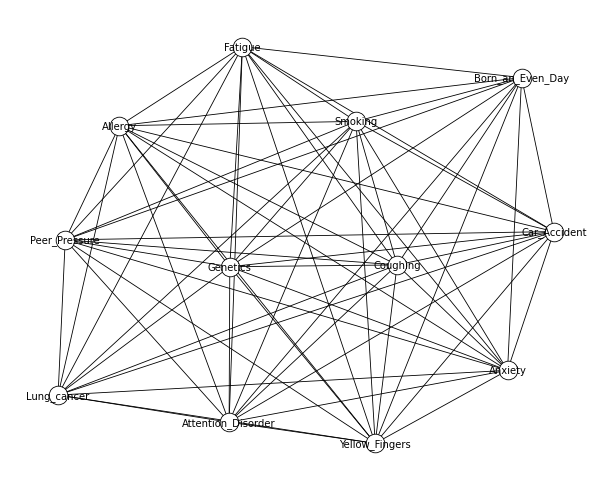

In [234]:
G.remove_edge('Lung_cancer', 'Born_an_Even_Day')
fig = plt.figure(1, figsize=(10, 8), dpi=60)
nx.draw(G, with_labels=True, node_size=500, node_color='w', edgecolors ='black') # , pos=position

We go through the whole edge list and remove the edges when two nodes are independent.

removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge

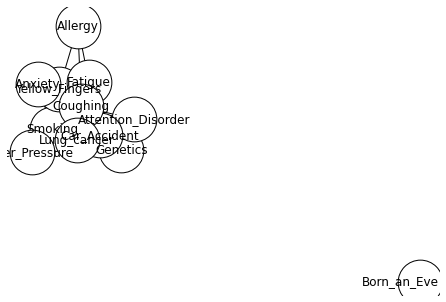

In [235]:
first_round_removed_edges = []
for (u, v) in combinations(feature_names, 2):
    res = pg.partial_corr(data=df, x=u, y=v, covar=[]).round(3)
    p_val = res['p-val'].item()
    if p_val > alpha:
        first_round_removed_edges.append((u, v))
        print("removing edge: ", (u, v))
        # reject H0, indicating u and v are independent
        # we then remove the edge
        if G.has_edge(u, v): # safety check
            G.remove_edge(u, v)
            
nx.draw(G, with_labels=True, node_size=2000, node_color='w', edgecolors ='black') # , pos=position

In [236]:
G.remove_node('Born_an_Even_Day')

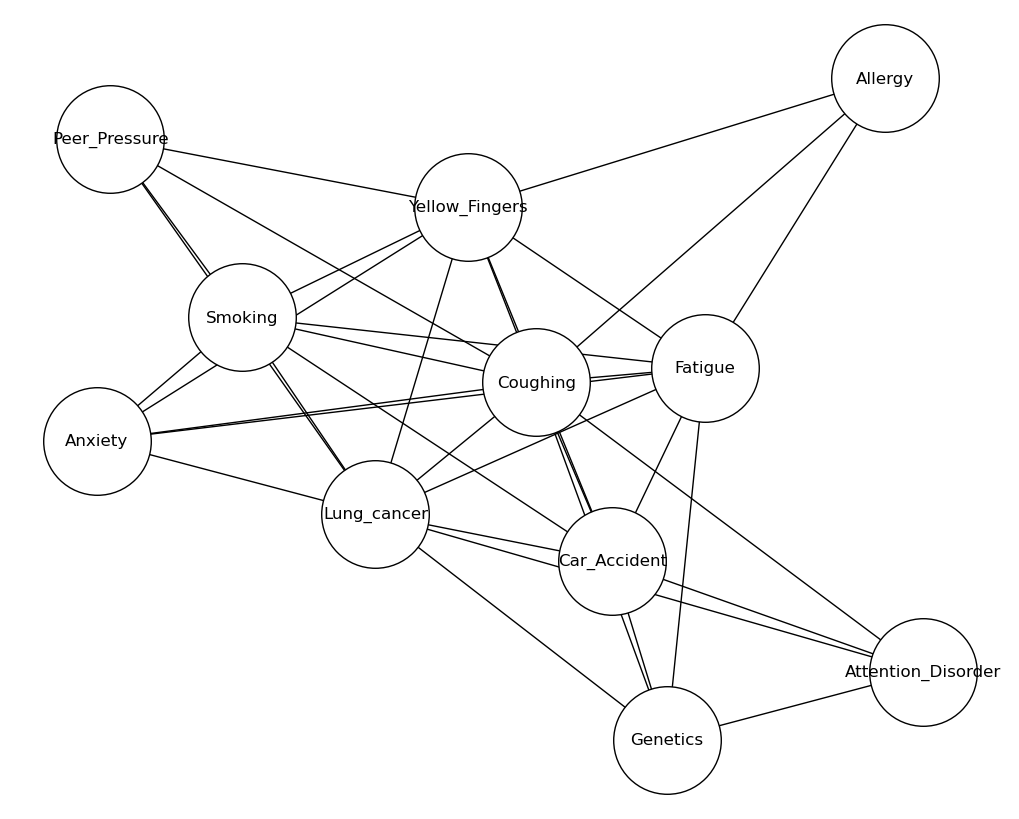

In [237]:
fig = plt.figure(1, figsize=(10, 8), dpi=100)
nx.draw(G, with_labels=True, node_size=6000, node_color='w', edgecolors ='black') # , pos=position

# plt.savefig('graph35.png')


In [238]:
print("Current number of edges in the graph is ", G.number_of_edges())

Current number of edges in the graph is  35


Next in **round 2**, we have conditioning set of size one. Let's start with the set {Fatigue}. - example

In [239]:
pg.partial_corr(data=df, x='Lung_cancer', y='Car_Accident', covar=['Fatigue']).round(3)

,n,r,CI95%,p-val
pearson,2000,-0.002,"[-0.05, 0.04]",0.923


The non-significant p-value shows that we fail to reject H0. We then remove the edge between Lung_cancer and Car_Accident.

We go through all combinations of nodes with different conditioning sets and remove edges. 

In [240]:
for z in feature_names:
    for (x, y) in combinations([node for node in feature_names if node != z], 2):
        res = pg.partial_corr(data=df, x=x, y=y, covar=[z]).round(3)
        p_val = res['p-val'].item()
        if p_val > alpha:
            print("removing edge: ", (x, y))
            # edge removal
            if G.has_edge(x, y): # safety check
                G.remove_edge(x, y)

removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
remo

removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
remov

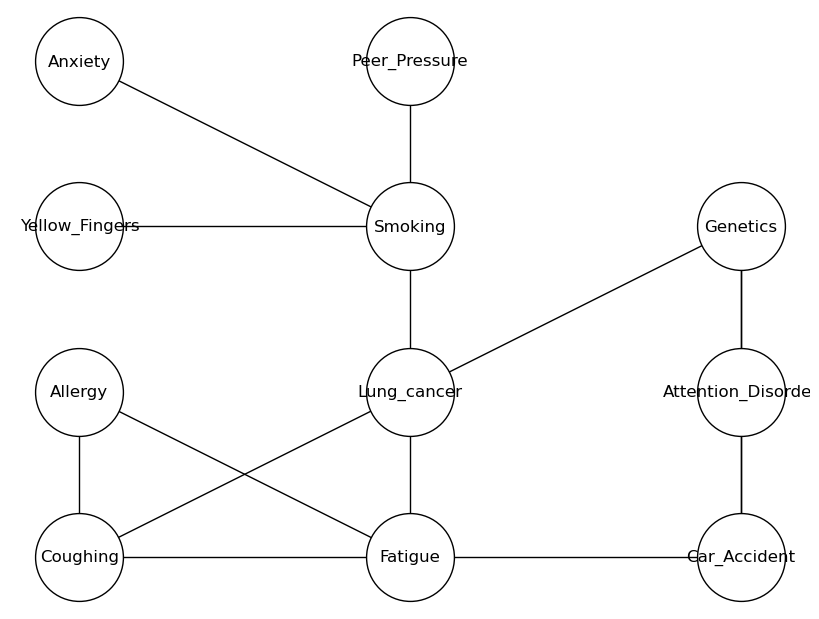

In [241]:
fig = plt.figure(1, figsize=(8, 6), dpi=100)
nx.draw(G, with_labels=True, node_size=4000, node_color='w', edgecolors ='black', pos=position) # , pos=position

# nx.draw(G, with_labels=True, node_size=6000, node_color='w', edgecolors ='black') # , pos=position

# plt.savefig('graph14.png')

In [242]:
print("Current number of edges in the graph is ", G.number_of_edges())

Current number of edges in the graph is  14


We can continue performing the conditional independence testing with larger and larger conditioning sets.

In [243]:
def sgs_algo(nodes, G, df, alpha=0.05):
    for size in range(len(nodes)-1):
        for z in combinations(nodes, size):
            for (x, y) in combinations([node for node in nodes if node not in z], 2):
                res = pg.partial_corr(data=df, x=x, y=y, covar=[*z]).round(3)
                p_val = res['p-val'].item()
                if p_val > alpha:
                    print("removing edge: ", (x, y))
                    # edge removal
                    if G.has_edge(x, y): # safety check
                        print("removing edge: ", (x, y))
                        G.remove_edge(x, y)
    return G

In [244]:
G = sgs_algo(feature_names, G, df, alpha=0.05)

removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge

removing edge:  ('Allergy', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day

removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing e

removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')


removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')

removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Allergy',

removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Allergy', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking',

removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Allergy', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Attention_Disorder',

removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge: 

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
r

removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removi

removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')

removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressur

removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'At

removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an

removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
rem

removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics',

removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing'

removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_D

removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking'

removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cance

removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Diso

removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
remo

removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('

removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 

removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
remov

removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removin

removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
re

removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_D

removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Smoking', 'Attention_Diso

removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('A

removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_

removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
r

removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
remo

removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smo

removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Cou

removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety',

removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Eve

removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', '

removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
re

removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Alle

removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edg

removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing e

removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fing

removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Ye

removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  

removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
remov

removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing 

removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_

removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing e

removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention

removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
r

removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removin

removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lu

removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:

removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Eve

removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_c

removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edg

removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('

removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anx

removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  

removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Allergy', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Allergy', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attentio

removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing 

removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Allergy', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Allergy', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  (

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fi

removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Car_Accident')
remov

removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Coughing')
removi

removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yell

removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('

removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:

removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Born

removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Geneti

removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Peer_Pressure'

removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder

removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day'

removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge: 

removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge: 

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accide

removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attentio

removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')

removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Bor

removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removi

removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'A

removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxie

removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day'

removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')

removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fing

removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Diso

removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edg

removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'B

removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_

removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing e

removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an

removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing ed

removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  

removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_a

removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
rem

removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  

removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', '

removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Aller

removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers',

removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetic

removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Gen

removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smok

removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  

removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', '

removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder'

removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smo

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Atten

removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born

removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiet

removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Peer_Pressure

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('An

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking'

removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('A

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', '

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Allergy', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'At

removing edge:  ('Allergy', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Y

removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'C

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing

removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Attention_Disorder', 'Alle

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removin

removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edg

removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
remo

removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing

removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
remo

removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coug

removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Smoking', 'Car_Accident')
removing ed

removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
remov

removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Fat

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Attention_Disorder', 'Fatigue')

removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day

removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Peer_Pressure', 'Gene

removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing 

removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge

removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edg

removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Di

removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Anxiety', 'Attention_Disorder')
removin

removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removin

removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 

removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('C

removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fin

removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yell

removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
r

removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
remo

removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Car

removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatig

removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accid

removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Born_an_Even_

removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Ye

removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  

removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:

removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 

removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiet

removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Ye

removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  

removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing e

removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Geneti

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure

removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')

removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'All

removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoki

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Ev

removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
remov

removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge: 

removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 

removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_

removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Allergy')

removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
remo

removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing 

removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Car_Accide

removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughi

removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing

removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fing

removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Smokin

removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Coughing')
remo

removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removin

removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetic

removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention

removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edg

removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure'

removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('

removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Dis

removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Co

removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiet

removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Atten

removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fi

removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
remov

removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
r

removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:

removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers

removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
rem

removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Yell

removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Peer_Pressure')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Anxiet

removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'C

removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Car_Accident', '

removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking'

removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', '

removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Born_an_Even_Day'

removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')
removing edge:

removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removin

removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Born_an_Even_Day', 'Car_Accident')
removing edge:  ('Smoking', 'Genetics')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Finge

removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Yellow_Fingers', 'B

removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Fatigue')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Attention_Disorder', 'Born_an_Even_Day')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Attention_Disorder', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_canc

removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Pee

removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Genetics', 'Born_an_

removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Anxiety', 'Genetics')
remov

removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Born_an_Even_Day')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
remov

removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Attention_Disorder', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Attention_Disorder', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Attention_Disorder')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Genetics')
removing edge:  ('

removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Anxiety')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Anxiety', 'Allergy')
remo

removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Fatigue')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Fatigue')

removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  

removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Peer_Pressure')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Smoking', 'Coughing

removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Car_Accident', 'Coughing')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Car_Accident', 'Allergy')
removing edge:  ('Genetics', 'Car_Accident')
removing edge:  ('Genetics', 'Fatigue')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Born_an_Even_Day', 'Lung_cancer')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Coughing')
removing edge:  ('Born_an_Even_Day', 'Coughing')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  ('Genetics', 'Allergy')
removing edge:  ('Born_an_Even_Day', 'Allergy')
removing edge:  ('Genetics', 'Born_an_Even_Day')
removing edge:  (

removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Coughing')
removing edge:  ('Yellow_Fingers', 'Fatigue')
removing edge:  ('Yellow_Fingers', 'Allergy')
removing edge:  ('Fatigue', 'Allergy')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
removing edge:  ('Yellow_Fingers', 'Lung_cancer')
removing edge:  ('Car_Accident', 'Lung_cancer')
removing edge:  ('Yellow_Fingers', 'Car_Accident')
re

removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Peer_Pressure', 'Fatigue')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Peer_Pressure', 'Car_Accident')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Peer_Pressure', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Attention_Disorder')
removing edge:  ('Peer_Pressure', 'Genetics')
removing edge:  ('Smoking', 'Coughing')
removing edge:  ('Smoking', 'Allergy')
removing edge:  ('Anxiety', 'Allergy')
removing edge:  ('Smoking', 'Fatigue')
removing edge:  ('Anxiety', 'Fatigue')
removing edge:  ('Smoking', 'Car_Accident')
removing edge:  ('Anxiety', 'Car_Accident')
removing edge:  ('Smoking', 'Born_an_Even_Day')
removing edge:  ('Anxiety', 'Born_an_Even_Day')
removing edge:  ('Smoking', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Attention_Disorder')
removing edge:  ('Anxiety', 'Genetics')
removing edge:  ('Anxiety', 'Peer_Pressure')
rem

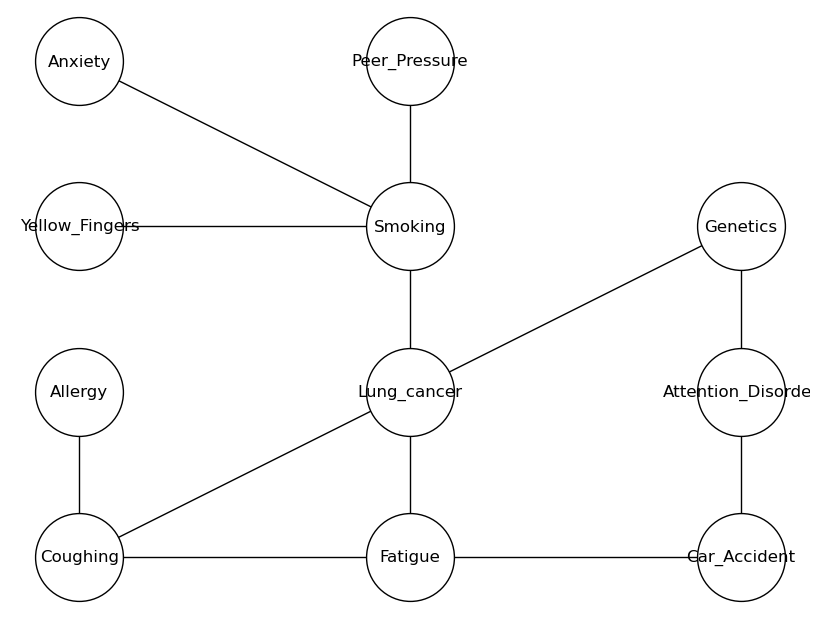

In [245]:
fig = plt.figure(1, figsize=(8, 6), dpi=100)

nx.draw(G, with_labels=True, node_size=4000, node_color='w', edgecolors ='black', pos=position) # , pos=position
# plt.savefig('SGS_graph.png')

In [211]:
# display(Image(filename="skeleton.png", width = 600, height = 800))

In [98]:
# The same skeleton as our known graph

### 2. Determine the v-structures

networkX does not support mixed graphs, so we convert the undirected graph to a directed graph. We use **black** edges to indicate directed edges and **red** bi-directional edges to indicate undirected edges.

Here we manully check the v-strucures. You can also implement an algorithm with Meek rules (http://proceedings.mlr.press/v89/katz19a/katz19a-supp.pdf) to find a complete orientation.

They need to be dependent if we condition on the one in the middle (collider)

In [246]:
# utility function to transfer undirected graph to directed graph 
# with bi-directional edges with red-color to indicate undirected edges
def to_directed(H):
    D = nx.DiGraph()
    nodes = list(H.nodes())
    edges = []
    for (u, v) in H.edges():
        edges.append((u, v, {"directed": False}))
        edges.append((v, u, {"directed": False}))
    D.add_nodes_from(nodes)
    D.add_edges_from(edges)
    return D

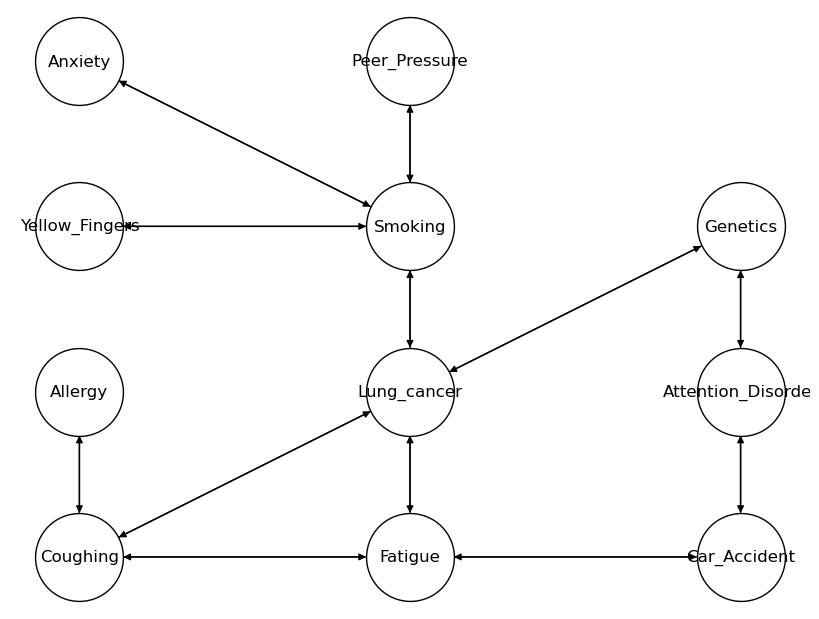

In [258]:
G_directed = to_directed(G)
colors = ['red' if G_directed[u][v]['directed']==True else 'black' for u,v in G_directed.edges()]
# nx.draw(G_directed, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=position, edge_color=colors)


fig = plt.figure(1, figsize=(8, 6), dpi=100)
nx.draw(G_directed, with_labels=True, node_size=4000, node_color='w', edgecolors ='black', pos=position)



In [259]:
# Black edges indicate not directed edges

From the first round we removed edges between Anxiety and PeerPressure, so we know $Anxiety \!\perp\!\!\!\perp PeerPressure$. Because there is a node Smoking that has undirected edges to Anxiety and Peer_Pressure, we can determine a v-structure for Anxiety -> Smoking <- Peer_Pressure. 

Based on the v-structure, we orient the directed edges (Anxiety -> Smoking) and (Peer_Pressure -> Smoking).

In [260]:
def edge_removal(edges, G):
    for (x, y) in edges:
        if G.has_edge(x, y):
            G.remove_edge(x, y)
        nx.set_edge_attributes(G, {(y, x): {"directed": True}})
    colors = ['red' if G_directed[u][v]['directed']==True else 'black' for u,v in G_directed.edges()]
    return G, colors

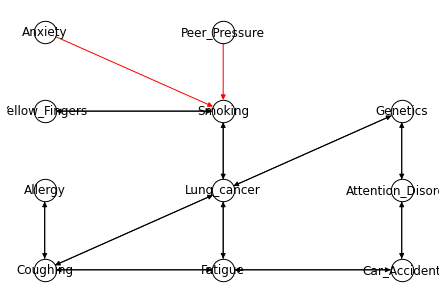

In [261]:
G_directed, colors = edge_removal([('Smoking', 'Peer_Pressure'), ('Smoking', 'Anxiety')], G_directed)
nx.draw(G_directed, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=position, edge_color=colors)

In [262]:
# We determin v-structures basen on these removed edges
first_round_removed_edges

[('Smoking', 'Genetics'),
 ('Smoking', 'Attention_Disorder'),
 ('Smoking', 'Born_an_Even_Day'),
 ('Smoking', 'Allergy'),
 ('Yellow_Fingers', 'Genetics'),
 ('Yellow_Fingers', 'Attention_Disorder'),
 ('Yellow_Fingers', 'Born_an_Even_Day'),
 ('Anxiety', 'Peer_Pressure'),
 ('Anxiety', 'Genetics'),
 ('Anxiety', 'Attention_Disorder'),
 ('Anxiety', 'Born_an_Even_Day'),
 ('Anxiety', 'Car_Accident'),
 ('Anxiety', 'Allergy'),
 ('Peer_Pressure', 'Genetics'),
 ('Peer_Pressure', 'Attention_Disorder'),
 ('Peer_Pressure', 'Born_an_Even_Day'),
 ('Peer_Pressure', 'Car_Accident'),
 ('Peer_Pressure', 'Fatigue'),
 ('Peer_Pressure', 'Allergy'),
 ('Genetics', 'Born_an_Even_Day'),
 ('Genetics', 'Allergy'),
 ('Attention_Disorder', 'Born_an_Even_Day'),
 ('Attention_Disorder', 'Fatigue'),
 ('Attention_Disorder', 'Allergy'),
 ('Born_an_Even_Day', 'Car_Accident'),
 ('Born_an_Even_Day', 'Fatigue'),
 ('Born_an_Even_Day', 'Allergy'),
 ('Born_an_Even_Day', 'Coughing'),
 ('Born_an_Even_Day', 'Lung_cancer'),
 ('Car_Acc

Basen on the following int=dependencies:

- $Anxiety \!\perp\!\!\!\perp PeerPressure$

- $Smoking \!\perp\!\!\!\perp Genetics$

- $LungCancer \!\perp\!\!\!\perp Allergy$

- $Fatigue \!\perp\!\!\!\perp AttentionDisorder$



We can determine the  v-structures:

- Anxiety -> Smoking <- Peer_Pressure (already found in previous step)

- Smoking -> Lung_cancer <- Genetics

- Lung_cancer -> Coughing <- Allergy

- Fatigue -> Car_Accident <- Attention_Disorder.

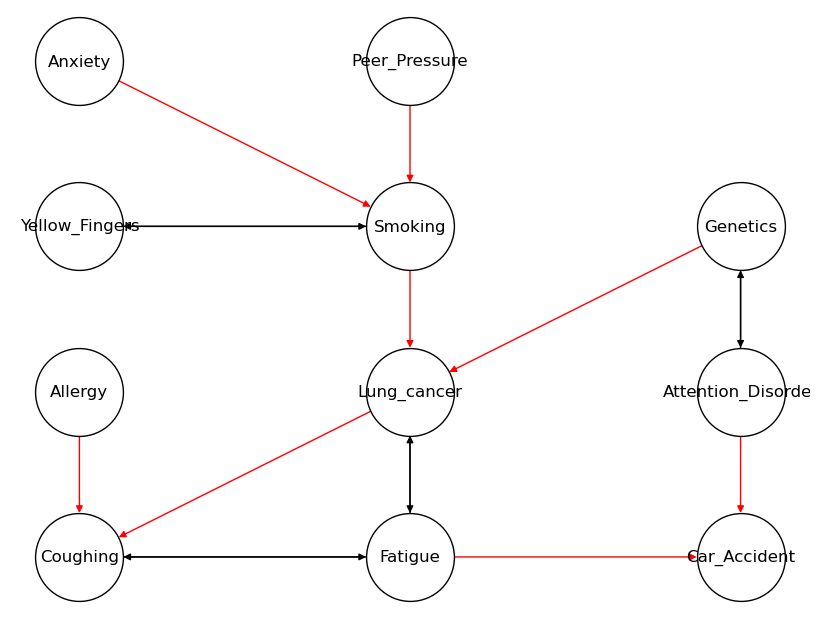

In [266]:
G_directed, colors = edge_removal([('Lung_cancer', 'Smoking'), ('Lung_cancer', 'Genetics')], G_directed)
G_directed, colors = edge_removal([('Coughing', 'Allergy'), ('Coughing', 'Lung_cancer')], G_directed)
G_directed, colors = edge_removal([('Car_Accident', 'Attention_Disorder'), ('Car_Accident', 'Fatigue')], G_directed)

fig = plt.figure(1, figsize=(8, 6), dpi=100)
nx.draw(G_directed, with_labels=True, node_size=4000, node_color='w', edgecolors ='black', pos=position, edge_color=colors)

plt.savefig('v_structures.png')

### Direct as many of the remaining edges as possible.

1. Yellow_Fingers -> Smoking <- Peer_Pressure & Yellow_Fingers -> Smoking <- Anxiety cannot be v-structures, because Yellow_Fingers are not independent from neither Anxiety nor Peer_Pressure. Therefore, we can direct this edge Smoking -> Yellow_Fingers

2. Coughing and Smoking are not independent, so they cannot construct v-structure Coughing -> Lung_cancer <- Smoking. We need to direct the edge Lung_cancer -> Coughing

3. Lung_cancer is adjecent to Fatigue, so Lung_cancer -> Coughing <- Fatigue is not a v-structure. WE direct the edge Lung_cancer -> Fatigue

4. Meek's rules -> we cannot construct circles, so we direct the edge Lung_cancer and Fatigue: Lung_cancer -> Fatigue

5. To keep Fatigue and Attention_Disorder independent, we need to direct the edge between Genetics and Attention_Disorder: Genetics -> Attention_Disorder

### Final graph with all directed edges

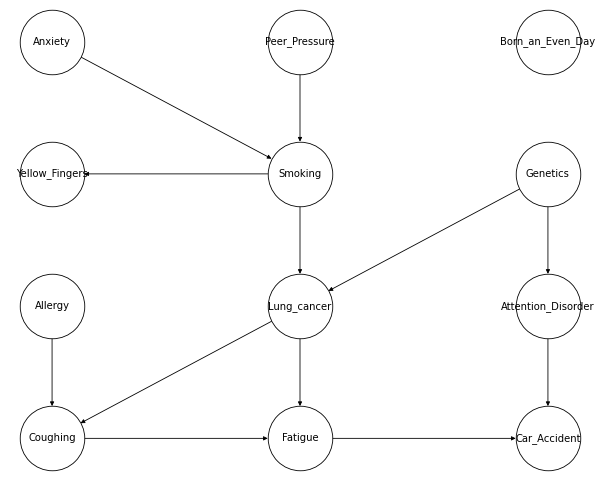

In [4]:
display(Image(filename="causal_graph.png", width = 600, height = 800))